<a href="https://colab.research.google.com/github/codebluecruz/Hyper-Parameter-Optimization-of-Decision-Tree-/blob/master/Final_operations%20with%20ROC%20Without%20HO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [189]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [190]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
  for filename in filenames:
    print(os.path.join(dirname, filename))

In [191]:
sdss_df = pd.read_csv('Romcom.csv', skiprows=0)

In [192]:
sdss_df.head()

,UniqueId,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,Sentiment_Rating
0,1,75 or over,Incomplete or Infrequent Bowel Movements,11/23/2009,miralax 17 gram oral powder packet,17116,5,3,"I have success taking this drug, but have had ...",4,Female,"Nausea , abdominal cramping, or gas may occur.",13,4
1,2,55-64,Rheumatoid Arthritis,11-01-2010,meloxicam,911,4,4,unfortunately this drug causes me migrane like...,2,Female,"Stomach upset, nausea , dizziness , or dia...",3,1
2,3,65-74,Sensation of Spinning or Whirling,3/19/2008,meclizine hcl,4520,4,4,"diagnosed with vertigo, this medication taken ...",4,Male,"Drowsiness, dry mouth , and tiredness may occur.",10,4
3,4,25-34,Depression,03-02-2011,mirtazapine tablet,13706,3,1,Placed on this medicine after being taken off ...,1,Female,"Dizziness , drowsiness, lightheadedness , inc...",20,1
4,5,19-24,Depression,04-01-2011,mirtazapine,13706,3,1,i have only been on this drug for one week. I ...,1,Female,"Dizziness , drowsiness, lightheadedness , inc...",28,1


In [193]:
sdss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29998 entries, 0 to 29997
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   UniqueId          29998 non-null  int64 
 1   Age               29998 non-null  object
 2   Condition         29998 non-null  object
 3   Date              29998 non-null  object
 4   Drug              29998 non-null  object
 5   DrugId            29998 non-null  int64 
 6   EaseofUse         29998 non-null  int64 
 7   Effectiveness     29998 non-null  int64 
 8   Reviews           29998 non-null  object
 9   Satisfaction      29998 non-null  int64 
 10  Sex               29998 non-null  object
 11  Sides             29998 non-null  object
 12  UsefulCount       29998 non-null  int64 
 13  Sentiment_Rating  29998 non-null  int64 
dtypes: int64(7), object(7)
memory usage: 3.2+ MB


In [194]:
sdss_df.describe()

,UniqueId,DrugId,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Sentiment_Rating
count,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000,29998.000000
mean,14999.500000,30174.666444,3.987366,3.665778,3.152577,6.708747,3.164944
std,8659.821024,49354.867556,1.364891,1.438950,1.618441,9.935583,1.721518
min,1.000000,4.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,7500.250000,6007.000000,3.000000,3.000000,1.000000,1.000000,1.000000
50%,14999.500000,6997.000000,5.000000,4.000000,3.000000,3.000000,3.000000
75%,22498.750000,19937.000000,5.000000,5.000000,5.000000,9.000000,5.000000
max,29998.000000,177317.000000,5.000000,5.000000,5.000000,178.000000,5.000000


In [195]:
sdss_df['Satisfaction'].value_counts()

5    9587
1    8246
4    4917
3    4226
2    3022
Name: Satisfaction, dtype: int64

In [196]:
sdss_df.columns.values

array(['UniqueId', 'Age', 'Condition', 'Date', 'Drug', 'DrugId',
       'EaseofUse', 'Effectiveness', 'Reviews', 'Satisfaction', 'Sex',
       'Sides', 'UsefulCount', 'Sentiment_Rating'], dtype=object)

In [197]:
sdss_df.drop(['UniqueId', 'Age', 'Date', 'DrugId', 'Reviews', 'Sex', 'Sides', 'Condition', 'Drug'], axis=1, inplace=True)
sdss_df.head(1)

,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Sentiment_Rating
0,5,3,4,13,4


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:2613: UserWarning: The `lvplot` function has been renamed to `boxenplot`. The original name will be removed in a future release. Please update your code. 
  warnings.warn(msg)


Text(0.5, 1.0, 'EaseofUSe')

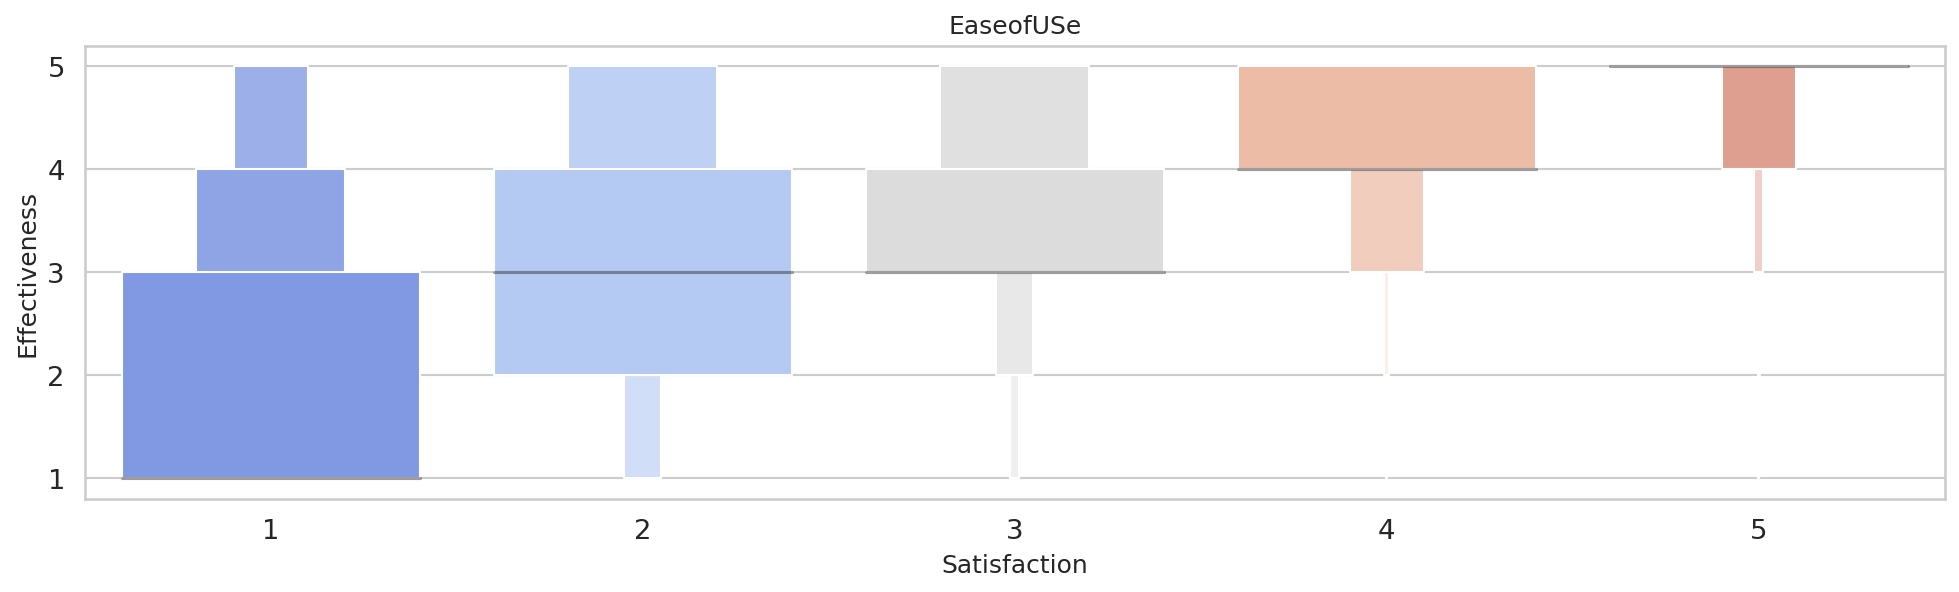

In [198]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.lvplot(x=sdss_df['Satisfaction'], y=sdss_df['Effectiveness'], palette='coolwarm')
ax.set_title('EaseofUSe')

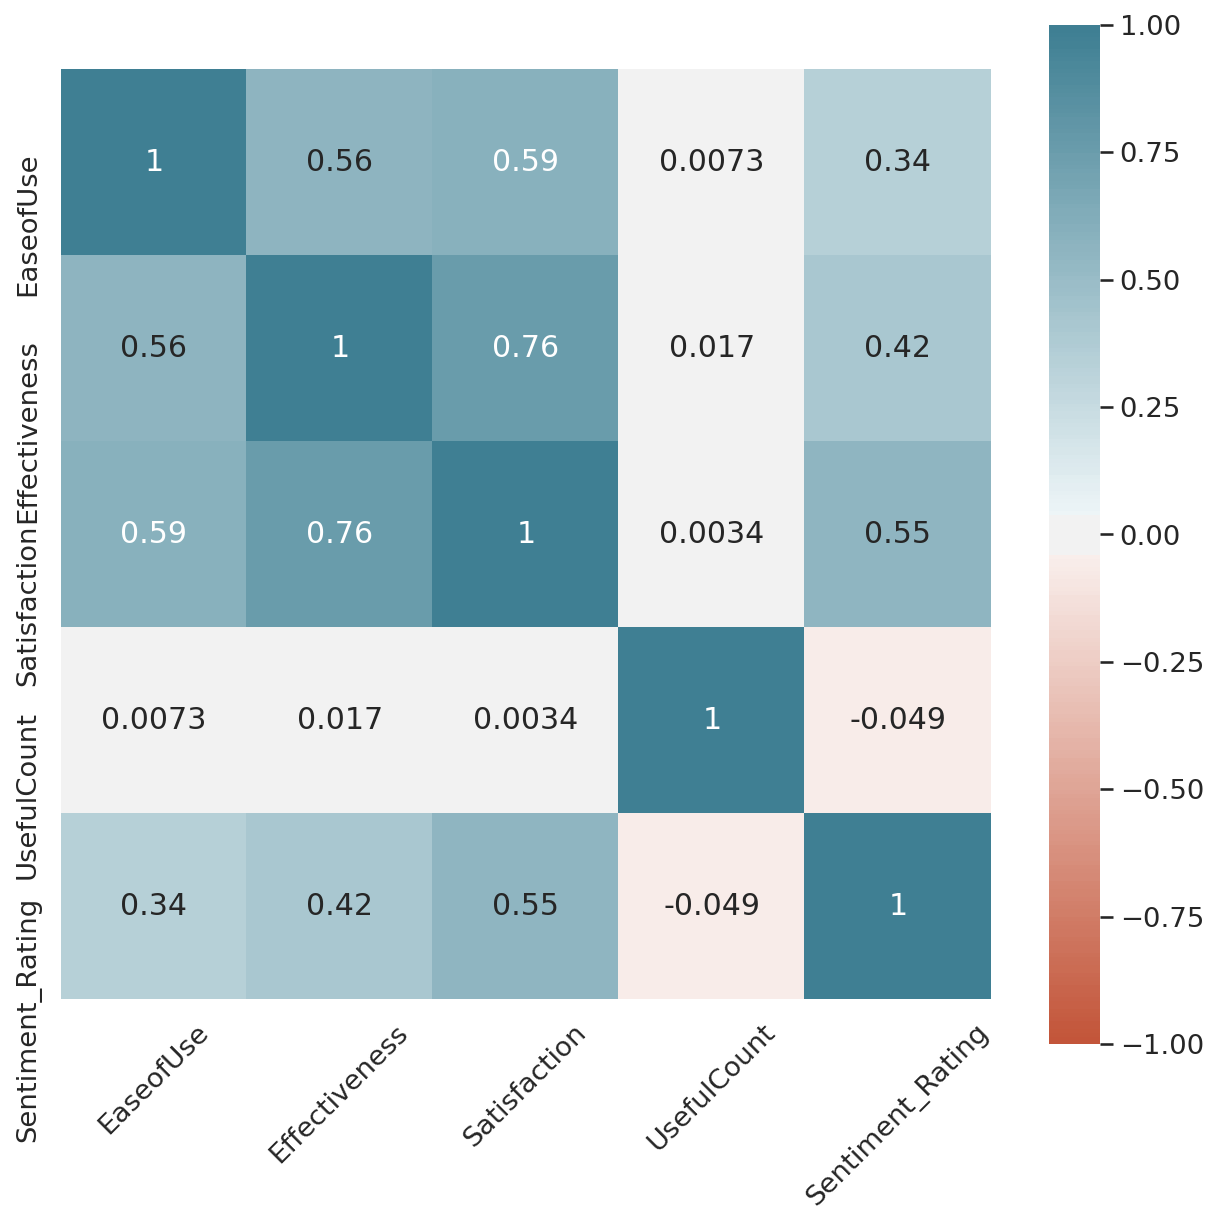

In [199]:
import seaborn as sns
# Heatmap of the correlation matrix
plt.rcParams['figure.figsize'] = [10,9]
sns.set(font_scale = 1.2)
corr = sdss_df.select_dtypes(include = 'int64').corr()
sns_heat = sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center=0,
cmap=sns.diverging_palette(20, 220, n=200), square=True);
plt.setp(sns_heat.get_xticklabels(), rotation = 45);

In [200]:
sdss_df_fe = sdss_df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(sdss_df_fe['Satisfaction'])
sdss_df_fe['Satisfaction'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(sdss_df_fe[['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating']])

# update dataframe 
sdss_df_fe = pd.concat((sdss_df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
#sdss_df_fe.drop(['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating'], axis=1, inplace=True)
sdss_df_fe.drop(['PCA_1', 'PCA_2', 'PCA_3'], axis=1, inplace=True)
sdss_df_fe.head()

,EaseofUse,Effectiveness,Satisfaction,UsefulCount,Sentiment_Rating
0,5,3,3,13,4
1,4,4,1,3,1
2,4,4,3,10,4
3,3,1,0,20,1
4,3,1,0,28,1


In [201]:
scaler = MinMaxScaler()
sdss = scaler.fit_transform(sdss_df_fe.drop('Satisfaction', axis=1))


In [202]:
X_train, X_test, y_train, y_test = train_test_split(sdss, sdss_df_fe['Satisfaction'], test_size=0.33)

In [203]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 61.93
Time consumed for training: 0.083 seconds
Time consumed for prediction: 0.36114 seconds


In [204]:
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(sdss_df_fe.drop('Satisfaction', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, sdss_df_fe['Satisfaction'], test_size=0.33)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 65.02
Time consumed for training: 0.006 seconds
Time consumed for prediction: 0.00352 seconds


In [205]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

XGBoost's prediction accuracy is: 65.35
Time consumed for training: 2.537
Time consumed for prediction: 0.15754 seconds


In [206]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 65.84
Time consumed for training: 0.113 seconds
Time consumed for prediction: 0.01842 seconds


In [207]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))


Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 64.67
Time consumed for training: 12.500 seconds
Time consumed for prediction: 3.54791 seconds


In [208]:
from sklearn.ensemble import GradientBoostingClassifier
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)

training_start = time.perf_counter()
gbk.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gbk.predict(X_test)
prediction_end = time.perf_counter()
acc_gbk = (preds == y_test).sum().astype(float) / len(preds)*100
gbk_train_time = training_end-training_start
gbk_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_gbk))
print("Time consumed for training: %4.3f seconds" % (gbk_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gbk_prediction_time))



Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 65.52
Time consumed for training: 6.790 seconds
Time consumed for prediction: 0.09858 seconds


In [209]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)


gbkpred = gbk.predict(X_test)
print(confusion_matrix(y_test, gbkpred ))
print(round(accuracy_score(y_test, gbkpred),2)*100)
GBKCV = (cross_val_score(gbk, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())


[[2146   92  156   76  174]
 [ 410  130  247  117  107]
 [ 268   75  557  291  228]
 [ 111   12  178  909  451]
 [  40    4   51  326 2744]]
66.0


In [210]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
training_start = time.perf_counter()
LR.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = LR.predict(X_test)
prediction_end = time.perf_counter()
acc_LR = (preds == y_test).sum().astype(float) / len(preds)*100
LR_train_time = training_end-training_start
LR_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_LR))
print("Time consumed for training: %4.3f seconds" % (LR_train_time))
print("Time consumed for prediction: %6.5f seconds" % (LR_prediction_time))


Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 62.27
Time consumed for training: 1.429 seconds
Time consumed for prediction: 0.00116 seconds


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [211]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC', 'LR', 'gbk'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc, acc_LR, acc_gbk],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time, LR_train_time, gbk_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time, LR_prediction_time, gbk_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
Random Forest,65.838384,0.113461,0.018417
gbk,65.515152,6.789530,0.098585
XGBoost,65.353535,2.536702,0.157541
Naive Bayes,65.020202,0.005514,0.003516
SVC,64.666667,12.499549,3.547914
LR,62.272727,1.429180,0.001161
KNN,61.929293,0.083066,0.361143


In [212]:

rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.66716418 0.66517413 0.67064677 0.66716418 0.66865672 0.67263682
 0.66467662 0.65621891 0.67496267 0.66600299]
Mean: 0.6673303963012216
Standard Deviation: 0.00485944058577167


In [213]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.6761194  0.67313433 0.66318408 0.66467662 0.66268657 0.66318408
 0.6721393  0.65323383 0.66699851 0.65853659]
Mean: 0.6653893301040839
Standard Deviation: 0.006599442944654401


In [214]:
importances = pd.DataFrame({
    'Feature': sdss_df_fe.drop('Satisfaction', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
Effectiveness,0.713374
Sentiment_Rating,0.161820
EaseofUse,0.109370
UsefulCount,0.015435


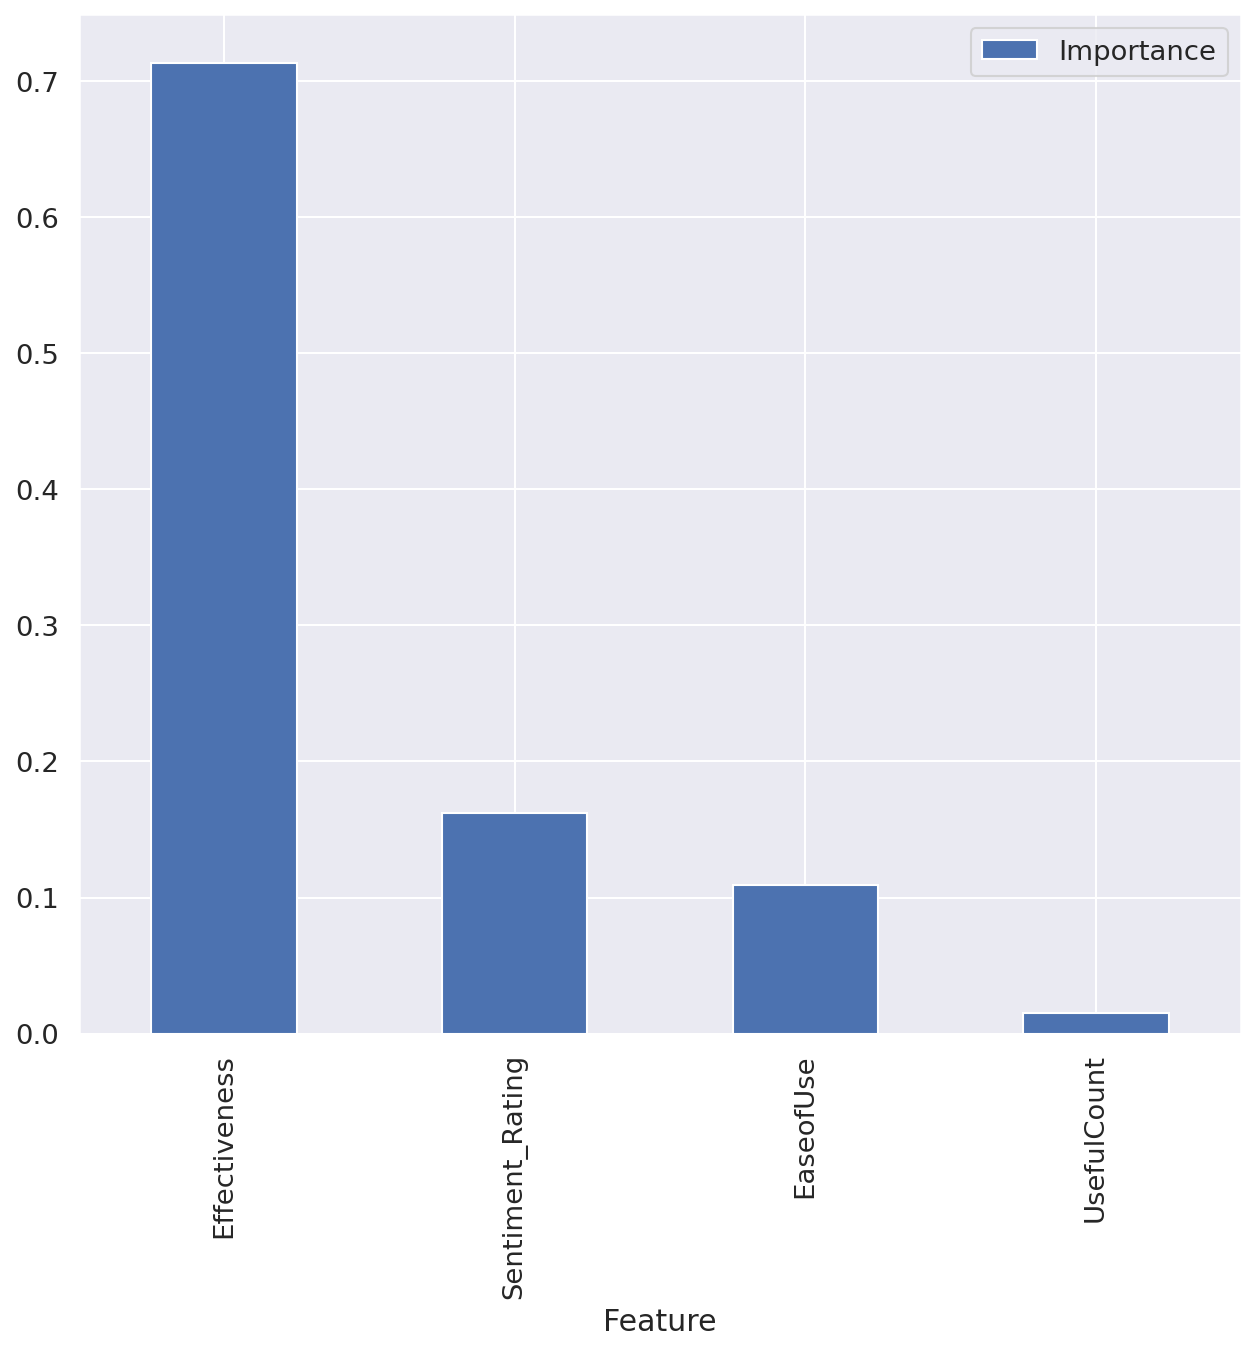

In [215]:
importances.plot.bar()

In [237]:
xgb_cv = XGBClassifier(n_estimators=100)
score = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print(score)

from sklearn.model_selection import KFold

# Defining Features and splitting the data as train and test set
features = sdss_df_fe[['EaseofUse', 'Effectiveness', 'UsefulCount', 'Sentiment_Rating']]
target = sdss_df_fe['Satisfaction']
target.isnull().sum().sum()
features = features.fillna(features.mean())
features.isnull().sum().sum()
train_data, test_data, train_targets, test_targets = train_test_split(features, target, test_size = 0.3, shuffle=True, random_state = 42)
print ("The Train set size ", X_train.shape)
print ("The Test set size ", X_test.shape)
num_folds=2
random_state=42
n_iter=50
kf = KFold(n_splits=num_folds, random_state=random_state)

[0.66766169 0.64676617 0.69004975 0.65920398 0.65671642 0.67562189
 0.64527363 0.65373134 0.67247387 0.66699851]
The Train set size  (20098, 4)
The Test set size  (9900, 4)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [238]:
X_train, X_test, y_train, y_test = train_test_split(sdss_df_fe.drop('Satisfaction', axis=1), sdss_df_fe['Satisfaction'],test_size=0.33)

In [239]:
xgboost = XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=1000, random_state=42)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

XGBoost's prediction accuracy WITH optimal hyperparameters is: 66.80


In [219]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.66517413 0.66218905 0.660199   0.65323383 0.65074627 0.6840796
 0.65024876 0.66119403 0.66450971 0.65156794]
Mean: 0.6603142327189339
Standard Deviation: 0.009642639963957327


In [220]:
unique, counts = np.unique(sdss_df_fe['Satisfaction'], return_counts=True)
dict(zip(unique, counts))

{0: 8246, 1: 3022, 2: 4226, 3: 4917, 4: 9587}

In [221]:
predictions = cross_val_predict(xgb, sdss_df_fe.drop('Satisfaction', axis=1), sdss_df_fe['Satisfaction'], cv=3)
confusion_matrix(sdss_df_fe['Satisfaction'], predictions)

array([[6665,  224,  503,  335,  519],
       [1287,  277,  760,  352,  346],
       [ 801,  127, 1646,  962,  690],
       [ 310,   28,  488, 2763, 1328],
       [ 107,    9,  123,  967, 8381]])

In [222]:
print("Precision:", precision_score(sdss_df_fe['Satisfaction'], predictions, average='micro'))
print("Recall:",recall_score(sdss_df_fe['Satisfaction'], predictions, average='micro'))

Precision: 0.6577771851456764
Recall: 0.6577771851456764


In [223]:
print("F1-Score:", f1_score(sdss_df_fe['Satisfaction'], predictions, average='micro'))

F1-Score: 0.6577771851456764


In [224]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(sdss_df_fe['Satisfaction'], predictions))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           0       0.73      0.81      0.77      8246
           1       0.42      0.09      0.15      3022
           2       0.47      0.39      0.42      4226
           3       0.51      0.56      0.54      4917
           4       0.74      0.87      0.80      9587

    accuracy                           0.66     29998
   macro avg       0.57      0.55      0.54     29998
weighted avg       0.63      0.66      0.63     29998



In [230]:
from sklearn.preprocessing import label_binarize
statis=sdss_df_fe['Satisfaction']
y = label_binarize(statis, classes=[0, 1, 2, 3, 4])
n_classes = y.shape[1]


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_pred1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_pred1.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

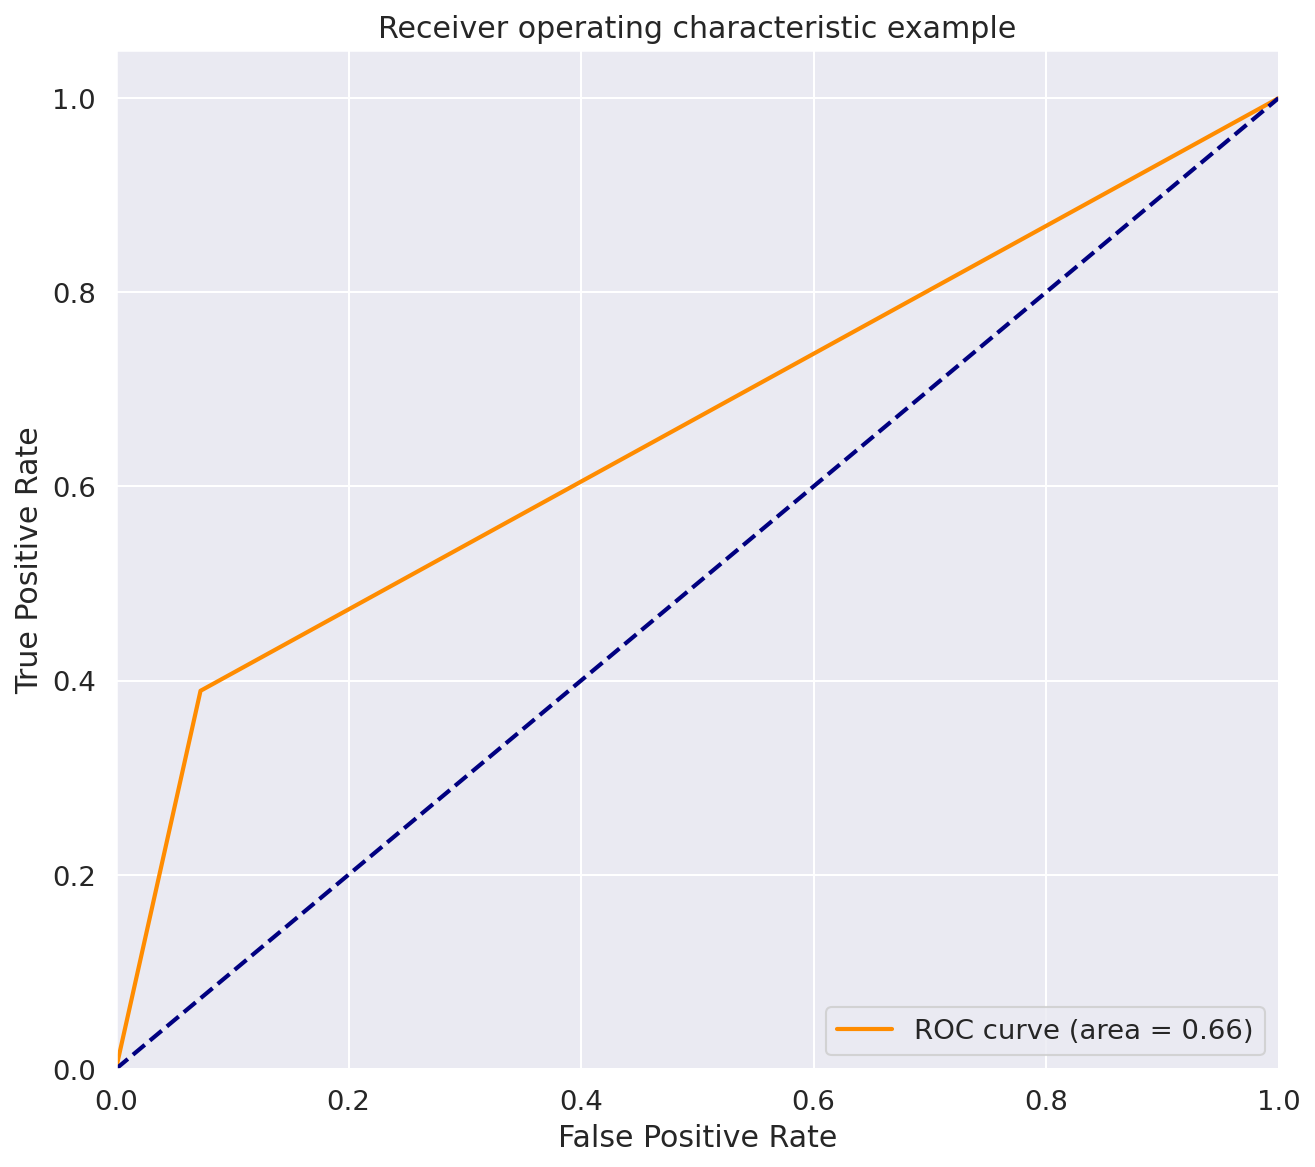

In [231]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

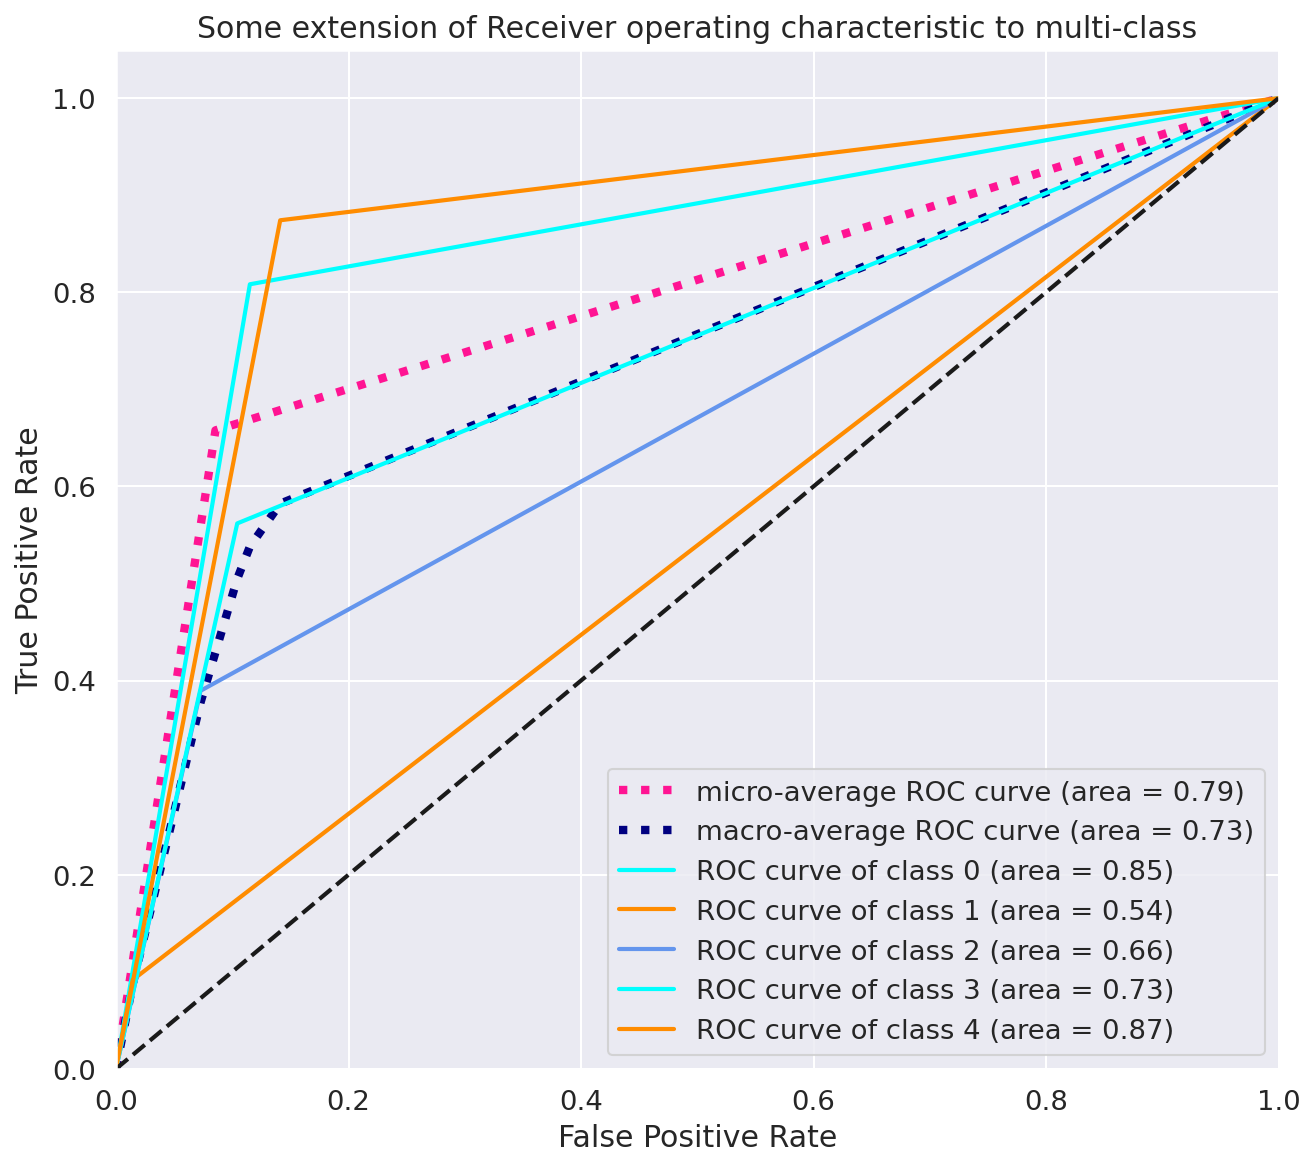

In [232]:
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()